Predicting NVIDIA stock adj-close using VAR model

reference：https://blog.csdn.net/mighty13/article/details/113819660

part 1: data preprocessing

1.1 import library and dataset

In [1]:
import pandas as pd
import numpy as np

import datetime as dt
import matplotlib.pyplot as plt

import statsmodels.tsa.stattools as stat
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import math

data = pd.read_csv('./NVDA 18-24.csv')
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-03-19,62.044998,62.337502,59.250000,60.250000,59.649902,71377200
1,2018-03-20,60.279999,62.787498,60.279999,62.395000,61.773552,55469600
2,2018-03-21,62.330002,63.000000,61.832500,62.139999,61.521091,43868800
3,2018-03-22,61.500000,61.970001,60.084999,60.462502,59.860310,55119600
4,2018-03-23,60.599998,60.625000,58.130001,58.242500,57.662403,73562000
...,...,...,...,...,...,...,...
1504,2024-03-11,864.289978,887.969971,841.659973,857.739990,857.739990,67836400
1505,2024-03-12,880.489990,919.599976,861.500000,919.130005,919.130005,66807500
1506,2024-03-13,910.549988,915.039978,884.349976,908.880005,908.880005,63571300
1507,2024-03-14,895.770020,906.460022,866.000000,879.440002,879.440002,60231800


1.2 set train-test ratio

In [2]:
test_size = 0.1               # proportion of dataset to be used as test set
train_size = 0.9                  # proportion of dataset to be used as cross-validation set

n = len(data)
n_90 = int(train_size * n)
n_10 = int(test_size * n)+1
test_len = n_10

In [3]:
full_time=data['Date']
train_time=data['Date'].iloc[:n_90]
test_time=data['Date'].iloc[n_90:]

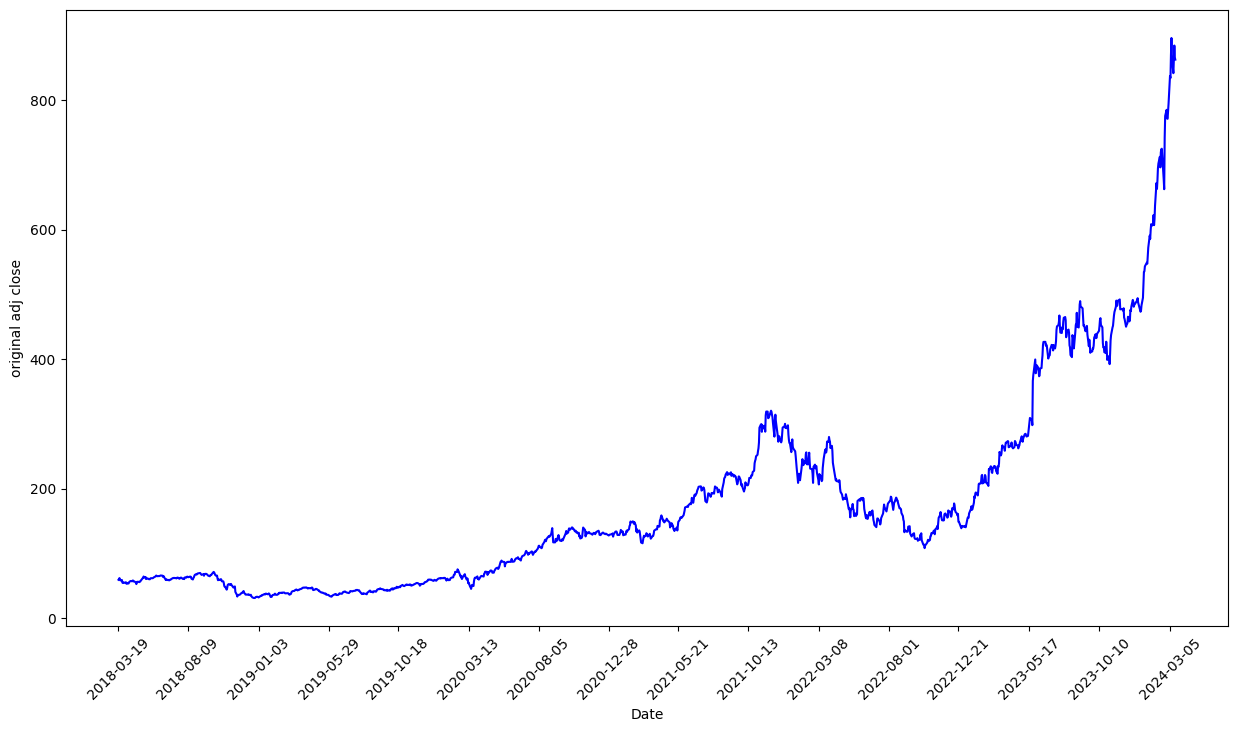

In [4]:
dates = pd.to_datetime(full_time)
n = 100
dates_to_show = dates[::n]

plt.figure(figsize=(15,8))
plt.plot(dates,data.iloc[:,3], color='blue')
plt.xticks(dates_to_show, rotation=45)
plt.xlabel('Date')
plt.ylabel('original adj close')
plt.show()

In [5]:
data.set_index(["Date"], inplace=True)

1.3 normalize dataste

In [6]:
data_90 = data.iloc[:n_90]
data_10 = data.iloc[n_90:]

scaler90 = StandardScaler()
train = scaler90.fit_transform(data_90)

scaler10 = StandardScaler()
test = scaler10.fit_transform(data_10)

data = pd.DataFrame(np.concatenate([train, test]), columns=data.columns)

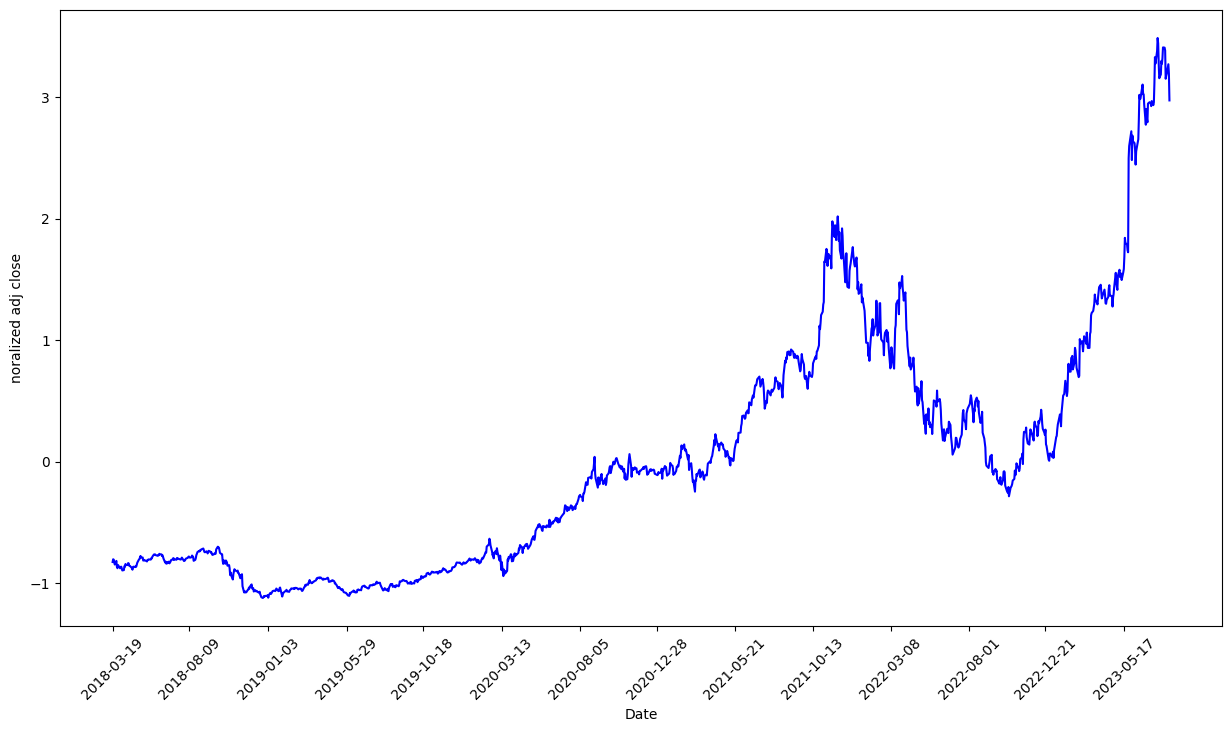

In [7]:
dates = pd.to_datetime(train_time)
n = 100
dates_to_show = dates[::n]

plt.figure(figsize=(15,8))
plt.plot(dates,train[:,3], color='blue')
plt.xticks(dates_to_show, rotation=45)
plt.xlabel('Date')
plt.ylabel('noralized adj close')
plt.show()

1.4 difference

In time series analysis, if a series has a unit root, it is non-stationary (p-value greater than 0.01), i.e., the mean, variance, and autocorrelation coefficient all change over time.

In [8]:
for i in range(6):
    pvalue = stat.adfuller(train[:,i], 1)[1]
    print(data.columns[i],": p-value for check Unit Root is",pvalue)

Open : p-value for check Unit Root is 0.9963045267850447
High : p-value for check Unit Root is 0.9958952761342585
Low : p-value for check Unit Root is 0.9917048656222253
Close : p-value for check Unit Root is 0.9916231146052235
Adj Close : p-value for check Unit Root is 0.991700676998527
Volume : p-value for check Unit Root is 5.230864123455103e-24


Use first-order difference operations to convert data into stationary

In [9]:
train_diff1 = train[1:,:] - train[:-1,:]
for i in range(5):
    pvalue = stat.adfuller(train_diff1[:,i], 1)[1]
    print(data.columns[i],": p-value for check Unit Root is",pvalue)

Open : p-value for check Unit Root is 0.0
High : p-value for check Unit Root is 0.0
Low : p-value for check Unit Root is 0.0
Close : p-value for check Unit Root is 0.0
Adj Close : p-value for check Unit Root is 0.0


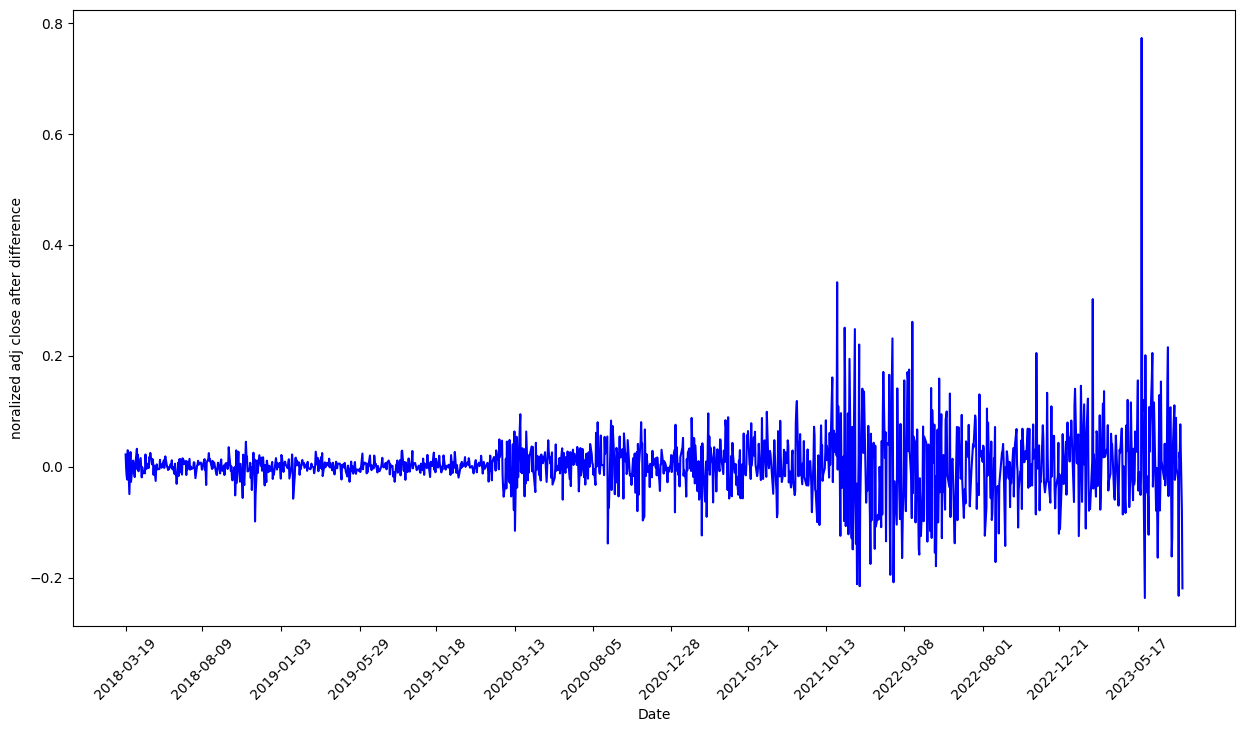

In [10]:
dates = pd.to_datetime(train_time[:-1])
n = 100
dates_to_show = dates[::n]

plt.figure(figsize=(15,8))
plt.plot(dates,train_diff1[:,3], color='blue')
plt.xticks(dates_to_show, rotation=45)
plt.xlabel('Date')
plt.ylabel('noralized adj close after difference')
plt.show()

1.5 order of VAR

Let the order gradually increase from 1, and when the AIC value is as small as possible, the maximum lag period can be determined. 

Using least squares, solve the coefficients for each equation and order the model by gradually increasing the order

In [11]:
rows, cols = train_diff1.shape
aicList = []
lmList = []

for p in range(1, 10):
    baseData = None
    for i in range(p, rows):
        tmp_list = list(train_diff1[i, :]) + list(train_diff1[i - p:i].flatten())
        if baseData is None:
            baseData = [tmp_list]
        else:
            baseData = np.r_[baseData, [tmp_list]]
    X = np.c_[[1] * baseData.shape[0], baseData[:, cols:]]
    Y = baseData[:, 0:cols]
    coefMatrix = np.matmul(np.matmul(np.linalg.inv(np.matmul(X.T, X)), X.T), Y)
    aic = np.log(np.linalg.det(np.cov(Y - np.matmul(X, coefMatrix), rowvar=False))) + 2 * (
            coefMatrix.shape[0] - 1) ** 2 * p / baseData.shape[0]
    aicList.append(aic)
    lmList.append(coefMatrix)

pd.DataFrame({"P": range(1, 10), "AIC": aicList})

,P,AIC
0,1,-46.938776
1,2,-47.146798
2,3,-46.509605
3,4,-44.722255
4,5,-41.613994
5,6,-36.878798
6,7,-30.184242
7,8,-21.273357
8,9,-9.725205


When p=2, the AIC value is the smallest. Therefore, the VAR model is rated at 2.

part 2: VAR Model

2.1 build model and predict

In [12]:
p = 2
n = rows
preddf = None
for i in range(test_len):
    predData = list(train_diff1[n+i-p:n+i].flatten())
    predVals = np.matmul([1]+predData,lmList[p-1])
    # Use the inverse arithmetic to restore the predicted value
    predVals = data.iloc[n+i,:].values + predVals
    if preddf is None:
         preddf = [predVals]
    else:
        preddf = np.r_[preddf, [predVals]]
    # Add a new record to the train_diff1
    train_diff1 = np.r_[train_diff1, [data.iloc[n+i+1,:].values[:6] - data.iloc[n+i,:].values[:6]]]

# Analyze and predict residuals
(np.abs(preddf - data.iloc[-test_len:data.shape[0],:6])/data.iloc[-test_len:data.shape[0],:6]).describe()

,Open,High,Low,Close,Adj Close,Volume
count,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000
mean,-0.117165,-0.110402,-0.054678,-0.070894,-0.071008,1.085896
std,0.742639,0.751020,0.446728,0.480373,0.479997,7.599209
min,-7.763726,-6.570797,-4.557090,-4.539467,-4.539375,-11.809785
25%,-0.098542,-0.081316,-0.125999,-0.140349,-0.140281,-0.808516
50%,-0.032739,-0.036894,-0.036545,-0.047918,-0.047935,-0.285794
75%,0.024370,0.031724,0.031190,0.025707,0.025697,0.832874
max,0.788466,2.366902,2.458024,2.538885,2.526338,69.716187


2.2 restore data

In [13]:
Y_test=pd.DataFrame(data_10['Adj Close'])
Y_test.set_index(test_time, inplace=True)
preddf= scaler10.inverse_transform(preddf)
preddf=pd.DataFrame(preddf)
preddf.set_index(test_time, inplace=True)

2.3 visual prediction result

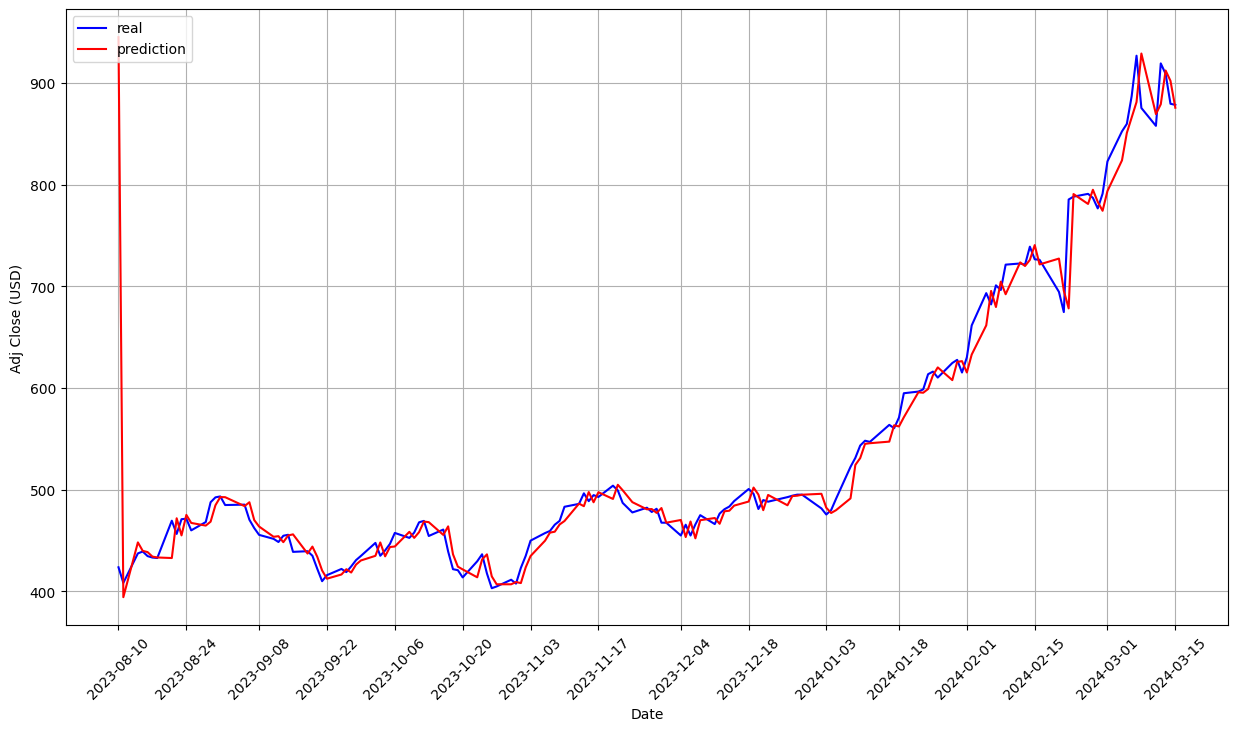

In [14]:
dates = pd.to_datetime(test_time)
n = 10
dates_to_show = dates[::n]

plt.figure(figsize=(15,8))
plt.plot(dates, Y_test['Adj Close'], c='blue', label='real')
plt.plot(dates, preddf.iloc[:,4], c='red', label='prediction')
plt.xticks(dates_to_show,rotation=45)
plt.ylabel('Adj Close (USD)')
plt.xlabel('Date')
plt.grid(True)
plt.legend(loc='upper left', prop={'size': 10})
plt.show()

2.4 evaluation

In [15]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100
rmse=math.sqrt(mean_squared_error(Y_test['Adj Close'],preddf.iloc[:,4]) )
y_pred_flat = preddf.iloc[:, 4].values.flatten()

mape=mape(Y_test['Adj Close'],preddf.iloc[:, 4])
print("RMSE on test set = %0.3f" % rmse)
print("MAPE on test set = %0.3f%%" % mape)


RMSE on test set = 45.433
MAPE on test set = 2.760%
